In [19]:
import os
import pandas as pd
import sime_runner
reload(sime_runner)
from sime_runner import *

In [31]:
user_dir = os.getenv('USERPROFILE')
proj_dir = os.path.join(user_dir, 'Desktop', 'AXA', 'PSCC18_paper')
# proj_dir = os.path.join(user_dir, r'OneDrive - Narodowe Centrum Badan Jadrowych\PSLFProjects\PSCC18_paper')

# lines
line_df = pd.read_excel(os.path.join(proj_dir, 'input_new.xlsx'), sheetname='lines')
line_pairs = tuple( tuple(map(int, line)) for line in line_df[['from', 'to']].values )
lines = range(36, 44) #range(len(line_pairs))

# buses
# lines = range(1, 31)
# line_pairs = [ (b,b) for b in lines ]

max_time = 1.0
positions = [50] #, [1, 25, 50, 75, 99]
id_step = 0

gen_models = ['genrou', 'gensal'] #'gencls'
gen_model = gen_models[0]
gen_trip = False
gen_oosmho = True
agc_on = 0
abus_ref = 0
drop_delta = 0.0466
case_name = 'new39_scopf'
test_name = '%s-sal39_trip%1d_refa%d_agc%d' % (gen_model, int(gen_trip), abus_ref, agc_on)
tsa_xl_name = case_name + '_' + test_name +'_tsa.xlsx'

print tsa_xl_name

new39_scopf_genrou-sal39_trip0_refa0_agc0_tsa.xlsx


In [32]:
tsa_stats = list()
tsa_xl_stats = list()

for line in lines:
    for pos in positions:
        try:
            tsa = run_sime_tsa(line, pos, max_time=max_time, drop_delta=drop_delta,
                               case_name=case_name, test_name=test_name, proj_dir=proj_dir,
                               gen_oosmho=gen_oosmho, gen_model=gen_models) #, gen_trip=gen_trip)
        except KeyError:
            print 'KeyError for line = %2d, pos = %2d' % (line, pos)
            continue

        tsa_xl_keys = filter(lambda key: not(key.endswith('df') or key.startswith('gen')), tsa.keys())
        tsa_xl = { key: tsa[key] for key in tsa_xl_keys }

        tsa_xl['gen_model'] = gen_model
        tsa_xl['gen_trip'] = gen_trip
        tsa_xl['line'] = line + id_step
        tsa_xl['line_from'] = line_pairs[line][0]
        tsa_xl['line_to'] = line_pairs[line][1]
        tsa_xl['pos'] = pos
        tsa_xl['oostr_test'] = bool(tsa_xl['oostr'])

        tsa_stats.append(tsa)
        tsa_xl_stats.append(tsa_xl)
        # print tsa['gen_dict']
        print 'line = %2d :: %2d-%2d, pos = %2d => %8s :: margin = %.2f, SIME_t = %.2f, OOS_t = %.2f, TEST = %s' % \
        (line, tsa_xl['line_from'], tsa_xl['line_to'], pos, tsa['result'], tsa['margin'],
         tsa['time'], tsa['oostr'] if tsa['oostr'] else -1, str(tsa['test_area']))

line = 36 :: 23-20, pos = 50 => instable :: margin = -4.33, SIME_t = 0.44, OOS_t = -1.00, TEST = True
line = 37 :: 24-28, pos = 50 =>   stable :: margin = 0.00, SIME_t = 0.32, OOS_t = -1.00, TEST = True
line = 38 :: 24-29, pos = 50 =>   stable :: margin = 0.00, SIME_t = 0.34, OOS_t = -1.00, TEST = True
line = 39 ::  4-30, pos = 50 =>   stable :: margin = 0.00, SIME_t = 0.26, OOS_t = -1.00, TEST = False
line = 40 ::  1- 3, pos = 50 =>   stable :: margin = 0.00, SIME_t = 0.78, OOS_t = -1.00, TEST = False
line = 41 ::  6-14, pos = 50 =>   stable :: margin = 0.00, SIME_t = 0.28, OOS_t = -1.00, TEST = True
line = 42 :: 18-25, pos = 50 => instable :: margin = 3.59, SIME_t = 0.38, OOS_t = -1.00, TEST = False
line = 43 :: 13-20, pos = 50 =>   stable :: margin = 0.00, SIME_t = 0.39, OOS_t = -1.00, TEST = True


In [33]:
tsa_xl_stats_df = pd.DataFrame(tsa_xl_stats)
tsa_xl_stats_df.to_excel(tsa_xl_name)

# Error handling

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline
from omib_plotter import *

tsa = tsa_stats[22]
tsa_df = tsa['df']

print 'SIME result =', tsa['result'], ': margin = ', tsa['margin']
print 'SIME time =', tsa['time']
print 'OOSMHO time =', tsa['oostr']
print tsa['gen_dict']['mach']
for key in filter(lambda test: test.endswith('test') or test.startswith('test') or test.endswith('sign'), tsa.keys()):
    print '%s: %s' % (key, tsa[key])

SIME result = stable : margin =  0
SIME time = 0.55611
OOSMHO time = None
{'NM': [39], 'CM': [31, 32, 33, 34, 35, 36, 37, 38]}
acc_test: True
dec_test: False
test_area: True
dec_sign: True
acc_sign: True


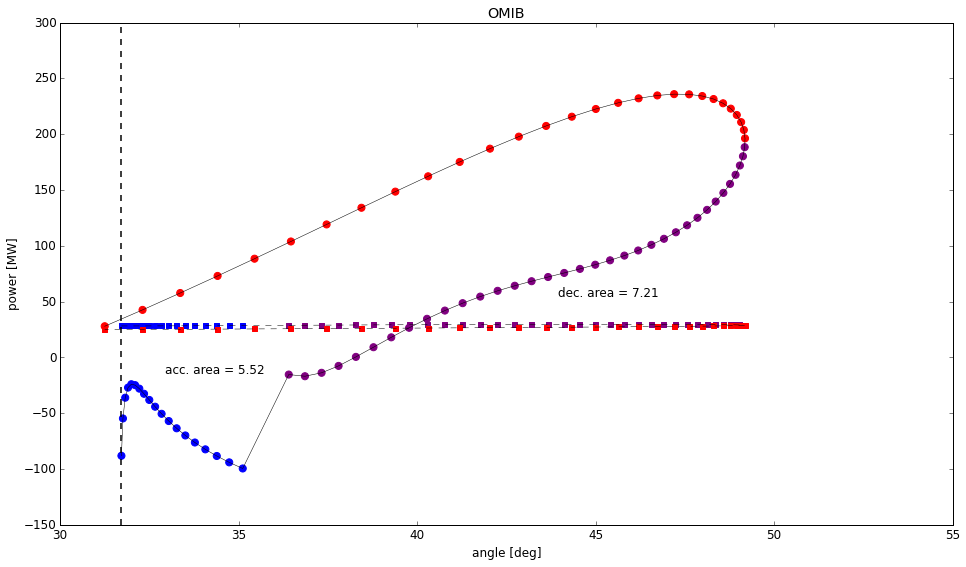

In [25]:
plot_omib_P_delta(plt, tsa)

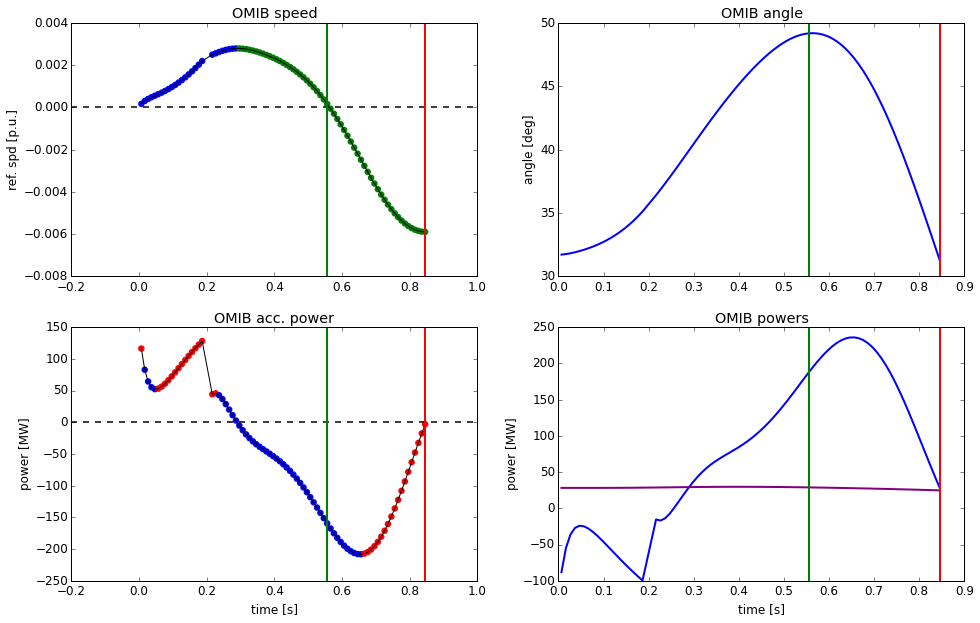

In [26]:
plot_omib_vars(plt, tsa)

# Trafo-gen test

In [18]:
gen_ids = range(31, 40)
tran_df = pd.read_excel(os.path.join(proj_dir, 'input_new.xlsx'), sheetname='trans')
tran_pairs = [ tuple(map(int, tran)) for tran in tran_df[['from', 'to']].values ]
gen_buses = filter(bool, map(lambda pair: pair[0] if pair[1] in gen_ids else pair[1] if pair[0] in gen_ids else None, tran_pairs))
gen_buses

[2, 10, 19, 20, 22, 23, 25, 29, 6]

In [85]:
# gen_lines = filter(lambda pair: pair[0] if pair[1] in gen_buses else pair[1] if pair[0] in gen_buses else None, line_pairs)
def get_nearest_faults(bus, pairs, time=0.0, time_delta=0.1, pos_ratio=0.01, bus_num_factor=100):
    bus_lines = filter(lambda pair: bus in pair, pairs)
    fault_lines = list()
    for n, pair in enumerate(bus_lines):
        fault_line = {
            'from': pair[0],
            'to': pair[1],
            'pos': pos_ratio * int(bus==pair[0]) + (1-pos_ratio) * int(bus==pair[1]),
            'num': str(bus * bus_num_factor + n),
            't': time + n * time_delta,
        }
        fault_lines.append(fault_line)
    

    def reduce_faults(f1, f2):
        f = f1.copy()
        if f.has_key('next'):
            # print 'has:', (f['from'], f['to']), 'next:', (f['next']['from'], f['next']['to'])
            f['next'] = reduce_faults(f['next'], f2)
        else:
            # print 'not:', (f['from'], f['to']), 'add:', (f2['from'], f2['to'])
            f['next'] = f2
        return f
    fault = reduce(reduce_faults, fault_lines)
    
    return fault


In [86]:
get_nearest_faults(6, line_pairs)

not: (5, 6) add: (6, 7)
has: (5, 6) next: (6, 7)
not: (6, 7) add: (6, 11)
has: (5, 6) next: (6, 7)
has: (6, 7) next: (6, 11)
not: (6, 11) add: (6, 14)


{'from': 5,
 'next': {'from': 6,
  'next': {'from': 6,
   'next': {'from': 6,
    'num': '603',
    'pos': 0.01,
    't': 0.30000000000000004,
    'to': 14},
   'num': '602',
   'pos': 0.01,
   't': 0.2,
   'to': 11},
  'num': '601',
  'pos': 0.01,
  't': 0.1,
  'to': 7},
 'num': '600',
 'pos': 0.99,
 't': 0.0,
 'to': 6}

In [37]:
dupa.has_key('a')

True